In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import cv2

In [3]:
data_dir ='/content/drive/MyDrive/datass'

In [4]:
Image_size = 256
Batch_size = 32
epochs = 10
channels = 3



In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle =True,
    seed = True,
    image_size =(Image_size,Image_size),
    batch_size = Batch_size

)

Found 2154 files belonging to 3 classes.


In [6]:
import os
class_names = os.listdir(data_dir)

In [7]:
data_iteration = dataset.as_numpy_iterator()

In [8]:
batcha = data_iteration.next()

In [9]:
batcha

(array([[[[121., 113., 126.],
          [120., 112., 125.],
          [125., 117., 130.],
          ...,
          [117., 105., 115.],
          [117., 105., 115.],
          [116., 104., 114.]],
 
         [[130., 122., 135.],
          [109., 101., 114.],
          [120., 112., 125.],
          ...,
          [109.,  97., 107.],
          [107.,  95., 105.],
          [104.,  92., 102.]],
 
         [[128., 120., 133.],
          [130., 122., 135.],
          [116., 108., 121.],
          ...,
          [114., 102., 112.],
          [113., 101., 111.],
          [112., 100., 110.]],
 
         ...,
 
         [[159., 151., 164.],
          [160., 152., 165.],
          [160., 152., 165.],
          ...,
          [135., 127., 142.],
          [132., 124., 139.],
          [130., 122., 137.]],
 
         [[161., 153., 166.],
          [161., 153., 166.],
          [160., 152., 165.],
          ...,
          [137., 129., 144.],
          [135., 127., 142.],
          [134., 126., 141.

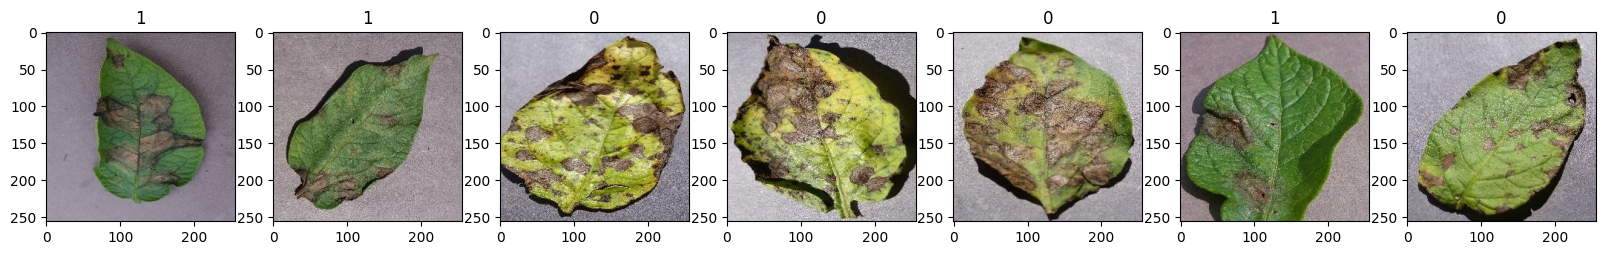

In [10]:
fig, ax = plt.subplots (ncols=7, figsize=(20,20))
for idx, img in enumerate(batcha[0][:7]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batcha[1][idx])

In [11]:
len(dataset)

68

In [12]:
train_size =0.8
len(dataset)* train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(Image_size,Image_size),
   layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (Batch_size,Image_size,Image_size,channels)
n_classes=3

model =models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)

54/54 [==============================] - 503s 4s/step - loss: 0.9187 - accuracy: 0.4942 - val_loss: 0.8820 - val_accuracy: 0.4740


In [27]:
model.evaluate(test_ds)

8/8 [==============================] - 18s 1s/step - loss: 0.9225 - accuracy: 0.4570


[0.9225293397903442, 0.45703125]

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


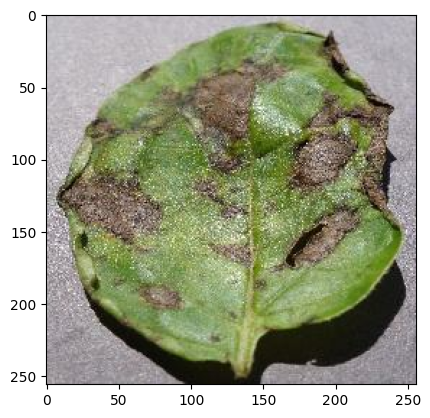

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
tf.keras.models.save_model(model,'my_model2.hdf5')


<ipython-input-29-07e813155dae>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model2.hdf5')


In [30]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [36]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import cv2
from PIL import Image, ImageOps
import numpy as np

# Load the trained model
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('my_model2.hdf5')
    return model

# Function to preprocess and make predictions on uploaded images
def import_and_predict(image_data, model, class_names):
    size = (256, 256)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    image = np.asarray(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_reshape = img[np.newaxis, ...]
    prediction = model.predict(img_reshape)
    return prediction

# Streamlit app UI
def main():
    st.title('Potato Plant Disease Classifier')
    st.write('This app predicts the type of potato plant disease from the uploaded image.')

    # Upload image file
    file = st.file_uploader("Please upload a potato plant image", type=["jpg", "png"])

    if file is None:
        st.text("Please upload an image file")
    else:
        # Display the uploaded image
        image = Image.open(file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        # Load the model
        model = load_model()
        class_names = ['class_1', 'class_2', 'class_3']  # Update with your actual class names

        # Make predictions
        predictions = import_and_predict(image, model, class_names)
        score = tf.nn.softmax(predictions[0])

        # Display predictions
        st.write("Prediction:")
        st.write(f"Class: {class_names[np.argmax(score)]}, Confidence: {100 * np.max(score):.2f}%")

if __name__ == '__main__':
    main()


Overwriting app.py


In [32]:
!pip install pyngrok


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

[##................] / fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.147.64.208:8501

npx: installed 22 in 3.651s
your url is: https://four-flowers-shop.loca.lt
2024-03-01 15:15:51.375733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 15:15:51.375802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 15:15:51.377564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 15:15:52.941227: W tensorflow/compiler/tf2tensorrt/utils/py